# Getting started with the PANDA dataset

This notebook shows a few methods to load and display images from the PANDA challenge dataset. The dataset consists of around 11.000 whole-slide images (WSI) of prostate biopsies from Radboud University Medical Center and the Karolinska Institute. 

This notebook was originally published as part of the Kaggle competition at https://www.kaggle.com/wouterbulten/getting-started-with-the-panda-dataset. To get started quickly, the notebook can be forked on Kaggle and directly executed on the dataset. For local use, make sure to update the paths to the training data. 

In [1]:
import os

# There are two ways to load the data from the PANDA dataset:
# Option 1: Load images using openslide
import openslide
# Option 2: Load images using skimage (requires that tifffile is installed)
import skimage.io

# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display

# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go


In [2]:
# Location of the training images
data_dir = '/kaggle/input/prostate-cancer-grade-assessment/train_images'
mask_dir = '/kaggle/input/prostate-cancer-grade-assessment/train_label_masks'

# Location of training labels
train_labels = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv').set_index('image_id')

# Quickstart: reading a patch in 4 lines

The example below shows in 4 lines how to extract a patch from one of the slides using OpenSlide.

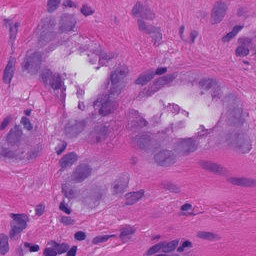

In [3]:
# Open the image (does not yet read the image into memory)
image = openslide.OpenSlide(os.path.join(data_dir, '005e66f06bce9c2e49142536caf2f6ee.tiff'))

# Read a specific region of the image starting at upper left coordinate (x=17800, y=19500) on level 0 and extracting a 256*256 pixel patch.
# At this point image data is read from the file and loaded into memory.
patch = image.read_region((17800,19500), 0, (256, 256))

# Display the image
display(patch)

# Close the opened slide after use
image.close()

# Using OpenSlide to load the data

In the following sections we will load data from the slides with [OpenSlide](https://openslide.org/api/python/). The benefit of OpenSlide is that we can load arbitrary regions of the slide, without loading the whole image in memory. Want to interactively view a slide? We have added an [interactive viewer](#Interactive-viewer-for-slides) to this notebook in the last section.

You can read more about the OpenSlide python bindings in the documentation: https://openslide.org/api/python/

## Loading a slide

Before we can load data from a slide, we need to open it. After a file is open we can retrieve data from it at arbitratry positions and levels.

```python
biopsy = openslide.OpenSlide(path)
# do someting with the slide here
biopsy.close()
```

For this tutorial, we created a small function to show some basic information about a slide. Additionally, this function display a small thumbnail of the slide. All images in the dataset contain this metadata and you can use this in your data pipeline.

In [4]:
def print_slide_details(slide, show_thumbnail=True, max_size=(600,400)):
    """Print some basic information about a slide"""
    # Generate a small image thumbnail
    if show_thumbnail:
        display(slide.get_thumbnail(size=max_size))

    # Here we compute the "pixel spacing": the physical size of a pixel in the image.
    # OpenSlide gives the resolution in centimeters so we convert this to microns.
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    
    print(f"File id: {slide}")
    print(f"Dimensions: {slide.dimensions}")
    print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
    print(f"Number of levels in the image: {slide.level_count}")
    print(f"Downsample factor per level: {slide.level_downsamples}")
    print(f"Dimensions of levels: {slide.level_dimensions}")


Running the cell below loads four example biopsies using OpenSlide. Some things you can notice:

- The image dimensions are quite large (typically between 5.000 and 40.000 pixels in both x and y).
- Each slide has 3 levels you can load, corresponding to a downsampling of 1, 4 and 16. Intermediate levels can be created by downsampling a higher resolution level.
- The dimensions of each level differ based on the dimensions of the original image.
- Biopsies can be in different rotations. This rotation has no clinical value, and is only dependent on how the biopsy was collected in the lab.
- There are noticable color differences between the biopsies, this is very common within pathology and is caused by different laboratory procedures.


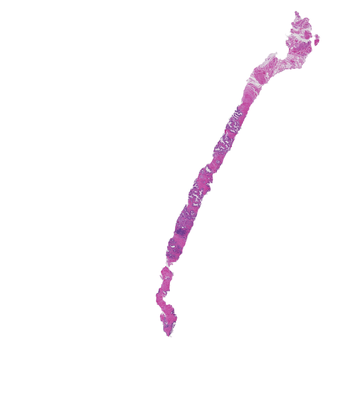

File id: OpenSlide('/kaggle/input/prostate-cancer-grade-assessment/train_images/005e66f06bce9c2e49142536caf2f6ee.tiff')
Dimensions: (31744, 37632)
Microns per pixel / pixel spacing: 0.452
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((31744, 37632), (7936, 9408), (1984, 2352))
ISUP grade: 1
Gleason score: 3+3




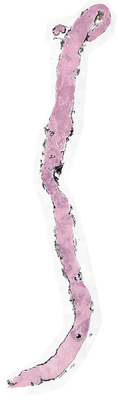

File id: OpenSlide('/kaggle/input/prostate-cancer-grade-assessment/train_images/00928370e2dfeb8a507667ef1d4efcbb.tiff')
Dimensions: (10752, 36352)
Microns per pixel / pixel spacing: 0.486
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((10752, 36352), (2688, 9088), (672, 2272))
ISUP grade: 5
Gleason score: 4+5




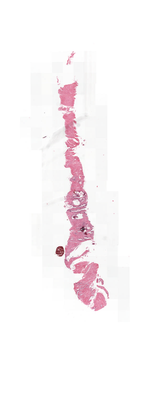

File id: OpenSlide('/kaggle/input/prostate-cancer-grade-assessment/train_images/007433133235efc27a39f11df6940829.tiff')
Dimensions: (9472, 24320)
Microns per pixel / pixel spacing: 0.486
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((9472, 24320), (2368, 6080), (592, 1520))
ISUP grade: 0
Gleason score: negative




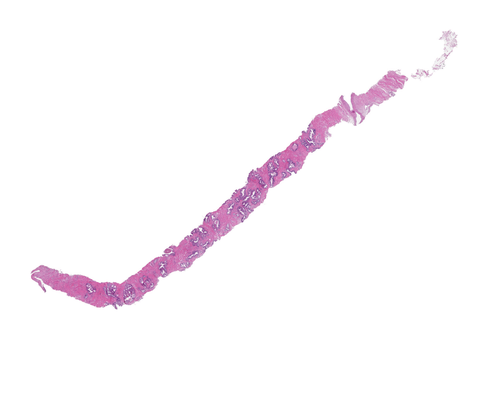

File id: OpenSlide('/kaggle/input/prostate-cancer-grade-assessment/train_images/024ed1244a6d817358cedaea3783bbde.tiff')
Dimensions: (26891, 21815)
Microns per pixel / pixel spacing: 0.503
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.000498225811406, 16.005841674527478)
Dimensions of levels: ((26891, 21815), (6722, 5453), (1680, 1363))
ISUP grade: 0
Gleason score: 0+0




In [5]:
example_slides = [
    '005e66f06bce9c2e49142536caf2f6ee',
    '00928370e2dfeb8a507667ef1d4efcbb',
    '007433133235efc27a39f11df6940829',
    '024ed1244a6d817358cedaea3783bbde',
]

for case_id in example_slides:
    biopsy = openslide.OpenSlide(os.path.join(data_dir, f'{case_id}.tiff'))
    print_slide_details(biopsy)
    biopsy.close()
    
    # Print the case-level label
    print(f"ISUP grade: {train_labels.loc[case_id, 'isup_grade']}")
    print(f"Gleason score: {train_labels.loc[case_id, 'gleason_score']}\n\n")

## Loading image regions/patches

With OpenSlide we can easily extract patches from the slide from arbitrary locations. Loading a specific region is done using the [read_region](https://openslide.org/api/python/#openslide.OpenSlide.read_region) function.

After opening the slide we can, for example, load a 512x512 patch from the lowest level (level 0) at a specific coordinate.


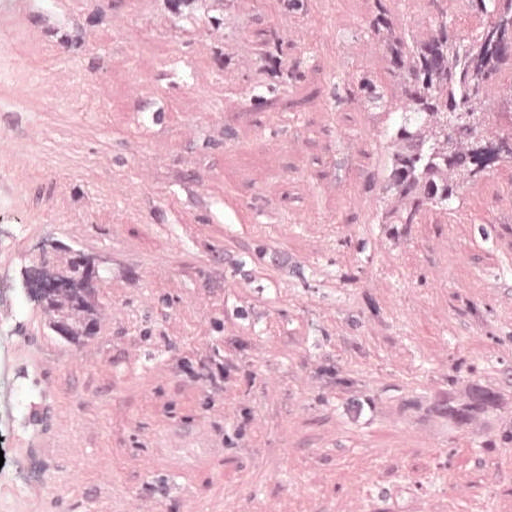

In [6]:
biopsy = openslide.OpenSlide(os.path.join(data_dir, '00928370e2dfeb8a507667ef1d4efcbb.tiff'))

x = 5150
y = 21000
level = 0
width = 512
height = 512

region = biopsy.read_region((x,y), level, (width, height))
display(region)


Using the `level` argument we can easily load in data from any level that is present in the slide. Coordinates passed to `read_region` are always relative to level 0 (the highest resolution).

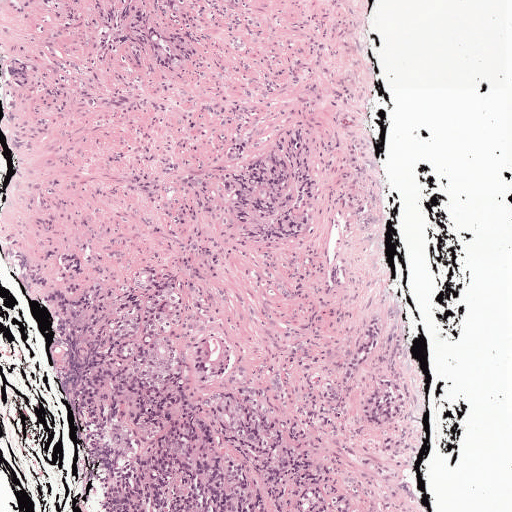

In [7]:
x = 5140
y = 21000
level = 1
width = 512
height = 512

region = biopsy.read_region((x,y), level, (width, height))
display(region)

In [8]:
biopsy.close()

## Loading label masks

Apart from the slide-level label (present in the csv file), almost all slides in the training set have an associated mask with additional label information. These masks directly indicate which parts of the tissue are healthy and which are cancerous. The information in the masks differ from the two centers:

- **Radboudumc**: Prostate glands are individually labelled. Valid values are:
  - 0: background (non tissue) or unknown
  - 1: stroma (connective tissue, non-epithelium tissue)
  - 2: healthy (benign) epithelium
  - 3: cancerous epithelium (Gleason 3)
  - 4: cancerous epithelium (Gleason 4)
  - 5: cancerous epithelium (Gleason 5)
- **Karolinska**: Regions are labelled. Valid values:
  - 0: background (non tissue) or unknown
  - 1: benign tissue (stroma and epithelium combined)
  - 2: cancerous tissue (stroma and epithelium combined)

The label masks of Radboudumc were semi-automatically generated by several deep learning algorithms, contain noise, and can be considered as weakly-supervised labels. The label masks of Karolinska were semi-autotomatically generated based on annotations by a pathologist.

The label masks are stored in an RGB format so that they can be easily opened by image readers. The label information is stored in the red (R) channel, the other channels are set to zero and can be ignored. As with the slides itself, the label masks can be opened using OpenSlide.

### Visualizing the masks (using PIL)

Using a small helper function we can display some basic information about a mask. To more easily inspect the masks, we map the int labels to RGB colors using a color palette. If you prefer something like `matplotlib` you can also use `plt.imshow()` to directly show a mask (without converting it to an RGB image).

In [9]:
def print_mask_details(slide, center='radboud', show_thumbnail=True, max_size=(400,400)):
    """Print some basic information about a slide"""

    if center not in ['radboud', 'karolinska']:
        raise Exception("Unsupported palette, should be one of [radboud, karolinska].")

    # Generate a small image thumbnail
    if show_thumbnail:
        # Read in the mask data from the highest level
        # We cannot use thumbnail() here because we need to load the raw label data.
        mask_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
        # Mask data is present in the R channel
        mask_data = mask_data.split()[0]

        # To show the masks we map the raw label values to RGB values
        preview_palette = np.zeros(shape=768, dtype=int)
        if center == 'radboud':
            # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
        elif center == 'karolinska':
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 1, 0, 0]) * 255).astype(int)
        mask_data.putpalette(data=preview_palette.tolist())
        mask_data = mask_data.convert(mode='RGB')
        mask_data.thumbnail(size=max_size, resample=0)
        display(mask_data)

    # Compute microns per pixel (openslide gives resolution in centimeters)
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    
    print(f"File id: {slide}")
    print(f"Dimensions: {slide.dimensions}")
    print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
    print(f"Number of levels in the image: {slide.level_count}")
    print(f"Downsample factor per level: {slide.level_downsamples}")
    print(f"Dimensions of levels: {slide.level_dimensions}")

The cells below shows two example masks from the dataset. The first mask is from Radboudumc and shows two different grades of cancer (shown in yellow and orange). The second mask is from Karolinska, the region that contains cancer is higlighted in red.

Note that, eventhough a biopsy contains cancer, not all epithelial tissue has to be cancerous. Biopsies can contain a mix of cancerous and healthy tissue.

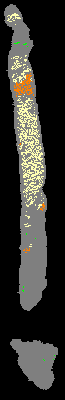

File id: OpenSlide('/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/08ab45297bfe652cc0397f4b37719ba1_mask.tiff')
Dimensions: (3328, 20224)
Microns per pixel / pixel spacing: 0.480
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((3328, 20224), (832, 5056), (208, 1264))


In [10]:
mask = openslide.OpenSlide(os.path.join(mask_dir, '08ab45297bfe652cc0397f4b37719ba1_mask.tiff'))
print_mask_details(mask, center='radboud')
mask.close()

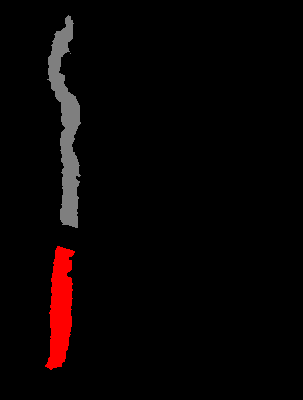

File id: OpenSlide('/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/090a77c517a7a2caa23e443a77a78bc7_mask.tiff')
Dimensions: (19919, 26327)
Microns per pixel / pixel spacing: 0.503
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.000529194200508, 16.00815659848122)
Dimensions of levels: ((19919, 26327), (4979, 6581), (1244, 1645))


In [11]:
mask = openslide.OpenSlide(os.path.join(mask_dir, '090a77c517a7a2caa23e443a77a78bc7_mask.tiff'))
print_mask_details(mask, center='karolinska')
mask.close()

### Visualizing masks (using matplotlib)

Given that the masks are just integer matrices, you can also use other packages to display the masks. For example, using matplotlib and a custom color map we can quickly visualize the different cancer regions:

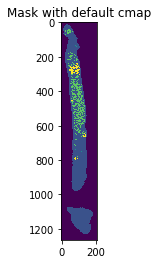

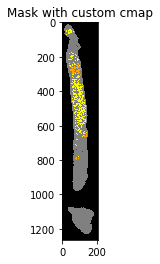

In [12]:
mask = openslide.OpenSlide(os.path.join(mask_dir, '08ab45297bfe652cc0397f4b37719ba1_mask.tiff'))
mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])

plt.figure()
plt.title("Mask with default cmap")
plt.imshow(np.asarray(mask_data)[:,:,0], interpolation='nearest')
plt.show()

plt.figure()
plt.title("Mask with custom cmap")
# Optional: create a custom color map
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
plt.imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
plt.show()

mask.close()

### Overlaying masks on the slides

As the masks have the same dimension as the slides, we can overlay the masks on the tissue to directly see which areas are cancerous. This overlay can help you identifying the different growth patterns. To do this, we load both the mask and the biopsy and merge them using PIL.

**Tip:** Want to view the slides in a more interactive way? Using a WSI viewer you can interactively view the slides. Examples of open source viewers that can open the PANDA dataset are [ASAP](https://github.com/computationalpathologygroup/ASAP) and [QuPath](https://qupath.github.io/). ASAP can also overlay the masks on top of the images using the "Overlay" functionality. If you use Qupath, and the images do not load, try changing the file extension to `.vtif`.

In [13]:
def overlay_mask_on_slide(slide, mask, center='radboud', alpha=0.8, max_size=(800, 800)):
    """Show a mask overlayed on a slide."""

    if center not in ['radboud', 'karolinska']:
        raise Exception("Unsupported palette, should be one of [radboud, karolinska].")

    # Load data from the highest level
    slide_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
    mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])

    # Mask data is present in the R channel
    mask_data = mask_data.split()[0]

    # Create alpha mask
    alpha_int = int(round(255*alpha))
    if center == 'radboud':
        alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
    elif center == 'karolinska':
        alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)
    
    alpha_content = PIL.Image.fromarray(alpha_content)
    preview_palette = np.zeros(shape=768, dtype=int)
    
    if center == 'radboud':
        # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
        preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
    elif center == 'karolinska':
        # Mapping: {0: background, 1: benign, 2: cancer}
        preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)
    
    mask_data.putpalette(data=preview_palette.tolist())
    mask_rgb = mask_data.convert(mode='RGB')

    overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
    overlayed_image.thumbnail(size=max_size, resample=0)

    display(overlayed_image)

> Note: In the example below you can also observe a few pen markings on the slide (dark green smudges). These markings are not part of the tissue but were made by the pathologists who originally checked this case. These pen markings are available on some slides in the training set.

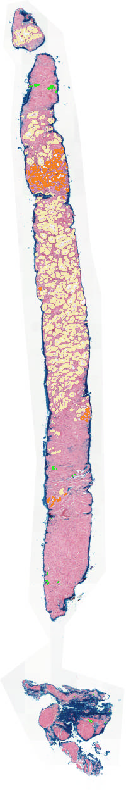

In [14]:
slide = openslide.OpenSlide(os.path.join(data_dir, '08ab45297bfe652cc0397f4b37719ba1.tiff'))
mask = openslide.OpenSlide(os.path.join(mask_dir, '08ab45297bfe652cc0397f4b37719ba1_mask.tiff'))
overlay_mask_on_slide(slide, mask, center='radboud')
slide.close()
mask.close()

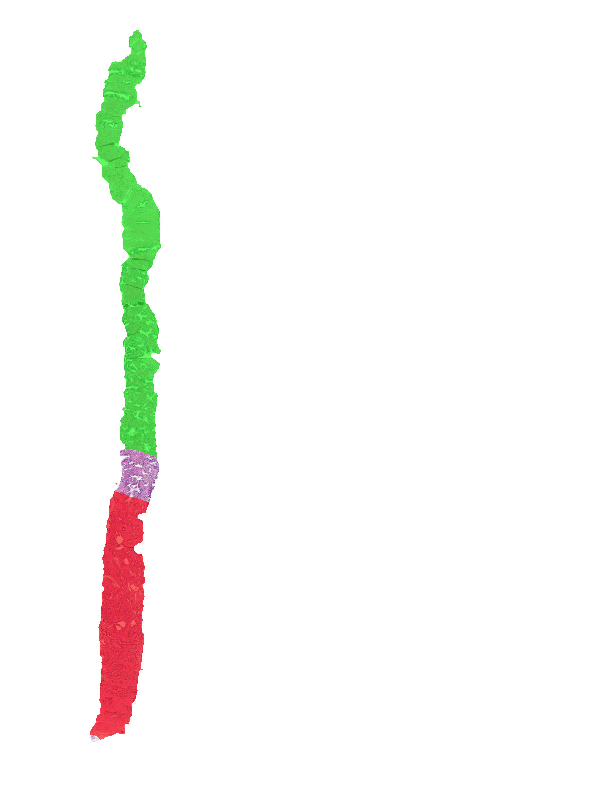

In [15]:
slide = openslide.OpenSlide(os.path.join(data_dir, '090a77c517a7a2caa23e443a77a78bc7.tiff'))
mask = openslide.OpenSlide(os.path.join(mask_dir, '090a77c517a7a2caa23e443a77a78bc7_mask.tiff'))
overlay_mask_on_slide(slide, mask, center='karolinska', alpha=0.6)
slide.close()
mask.close()

# Using scikit-image & tifffile to load the data

As an alternative to OpenSlide, the slides in the PANDA dataset can also be loaded using [scikit-image](https://scikit-image.org/) with [tifffile](https://pypi.org/project/tifffile/) as the backend.

> **Note:** scikit-image (<= 0.16.x) uses an internal version of the tif loader if the tifffile packages is not installed. This internal version does not support JPEG compression and can not be used to load the images in the dataset. Make sure tifffile is installed before running the examples below. This requirement is already met when running this code in a notebook on Kaggle.

## Loading a slide

Loading a slide with [scikit-image](https://scikit-image.org/) is similar to loading slides with OpenSlide. The major difference between scikit-image and OpenSlide is that scikit-image loads the image into memory. To extract a certain region of the image, you will need to load the whole image at one of the levels.

The images in the PANDA dataset are relatively small because each biopsy was individually extracted from the source slide. The small size makes it possible to load the slides directly into memory. Still, upon loading the image is uncompressed resulting in larger memory usage.

Slides are loaded using the [MultiImage](https://scikit-image.org/docs/0.16.x/api/skimage.io.html?highlight=multiimage#skimage.io.MultiImage) class; this class gives the ability to access the individual levels of the image. By default, MultiImage tries to conserve memory usage by only caching the last image level that was accessed.


In [16]:
biopsy = skimage.io.MultiImage(os.path.join(data_dir, '0b373388b189bee3ef6e320b841264dd.tiff'))

The code below loads each individual level. You can check the memory usage of the kernel to see that loading the lowest level can require a considerate amount of memory.

In [17]:
for i,level in enumerate(biopsy):
    print(f"Biopsy level {i} dimensions: {level.shape}")
    print(f"Biopsy level {i} memory size: {level.nbytes / 1024**2:.1f}mb")

Biopsy level 0 dimensions: (9728, 20224, 3)
Biopsy level 0 memory size: 562.9mb
Biopsy level 1 dimensions: (2432, 5056, 3)
Biopsy level 1 memory size: 35.2mb
Biopsy level 2 dimensions: (608, 1264, 3)
Biopsy level 2 memory size: 2.2mb


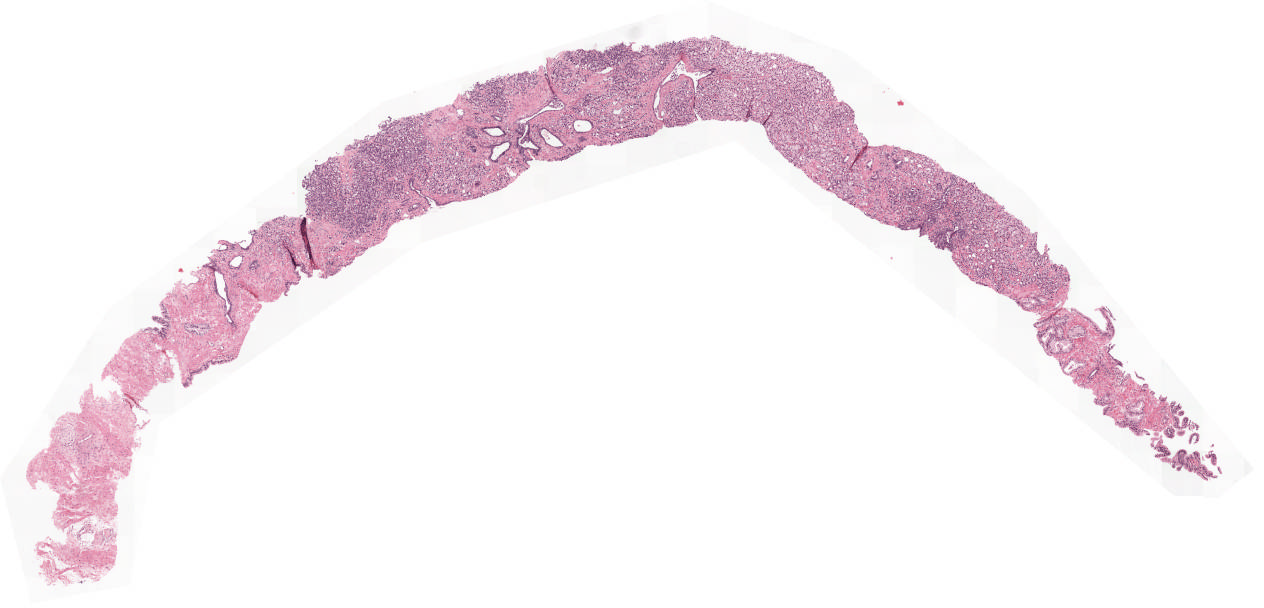

In [18]:
display(PIL.Image.fromarray(biopsy[-1]))

In [19]:
# Deleting the object frees up memory
del biopsy

If you are only interested in the lowest level (highest magnification), you can also load level 0 using [imread](https://scikit-image.org/docs/0.16.x/api/skimage.io.html?highlight=imread#skimage.io.imread):

In [20]:
biopsy_level_0 = skimage.io.imread(os.path.join(data_dir, '0b373388b189bee3ef6e320b841264dd.tiff'))
print(biopsy_level_0.shape)
del biopsy_level_0

(9728, 20224, 3)


## Loading image regions

Similar to OpenSlide, we can extract regions from the whole image. Because the image is already in memory, this boils down to a slice on the numpy array. To illustrate we use the same coordinates as in the OpenSlide example:

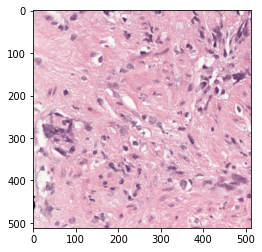

In [21]:
biopsy = skimage.io.MultiImage(os.path.join(data_dir, '00928370e2dfeb8a507667ef1d4efcbb.tiff'))

x = 5150
y = 21000
level = 0
width = 512
height = 512

patch = biopsy[0][y:y+width, x:x+height]

# You can also visualize patches with matplotlib
plt.figure()
plt.imshow(patch)
plt.show()


To load the same region from level 1, we have to devide the coordinates with the downsample factor (4 per level). This is different from Openslide that always works with coordinates from level 0.

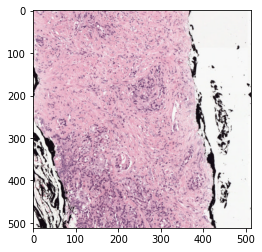

In [22]:
x = 5150 // 4
y = 21000 // 4
width = 512
height = 512

patch = biopsy[1][y:y+width, x:x+height]

plt.figure()
plt.imshow(patch)
plt.show()

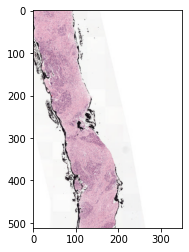

In [23]:
x = 5150 // (4*4)
y = 21000 // (4*4)
width = 512
height = 512

patch = biopsy[2][y:y+width, x:x+height]

plt.figure()
plt.imshow(patch)
plt.show()

In [24]:
# Free up memory
del biopsy

## Loading label masks

Loading label masks using scikit-image is similar to loading the slides. As the label information is in the R channel, other channels can be discarded. Please refer to the "OpenSlide - Loading label masks" section for more information about the contents of the label masks.

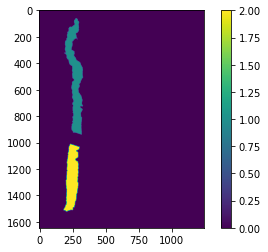

In [25]:
maskfile = skimage.io.MultiImage(os.path.join(mask_dir, '090a77c517a7a2caa23e443a77a78bc7_mask.tiff'))
mask_level_2 = maskfile[-1][:,:,0]

plt.figure()
plt.imshow(mask_level_2)
plt.colorbar()
plt.show()

In [26]:
del maskfile

# Interactive viewer for slides

Using [Plotly](https://kite.com/python/docs/plotly.graph_objs) we can make an interactive viewer that works inside a notebook. Using this viewer you can load any image from the PANDA dataset and interactively zoom in to specific regions. This viewer is a great way of inspecting the data in more detail.

> **Note:** The code below only works when you run this notebook yourself. The output is not shown when purely viewing the notebook as it requires access to the source image.

Want to investigate slides locally on your machine? Using a WSI viewer you can interactively view the slides on your own machine. Examples of open source viewers that can open the PANDA dataset are [ASAP](https://github.com/computationalpathologygroup/ASAP) and [QuPath](https://qupath.github.io/). ASAP can also overlay the masks on top of the images using the "Overlay" functionality. If you use Qupath, and the images do not load, try changing the file extension to `.vtif`.



In [27]:
class WSIViewer(object):
    def __init__(self, plot_size = 1000):
        self._plot_size = plot_size
        
    def set_slide(self, slide_path):      
        self._slide = openslide.open_slide(slide_path)
        self._base_dims = self._slide.level_dimensions[-1]
        self._base_ds = self._slide.level_downsamples[-1]
        img_arr = self._slide.read_region((0,0), len(self._slide.level_dimensions[-1]), (self._base_dims[0], self._base_dims[1]))
        
        self._fig = go.FigureWidget(data=[{'x': [0, self._base_dims[0]], 
                                           'y': [0, self._base_dims[1]], 
                                           'mode': 'markers',
                                           'marker': {'opacity': 0}}], # invisible trace to init axes and to support autoresize
                                    layout={'width': self._plot_size, 'height': self._plot_size, 'yaxis' : dict(scaleanchor = "x", scaleratio = 1)})  
        # Set background image
        self._fig.layout.images = [go.layout.Image(
            source = img_arr,  # plotly now performs auto conversion of PIL image to png data URI
            xref = "x",
            yref = "y",
            x = 0,
            y = 0,
            sizex = self._base_dims[0],
            sizey = self._base_dims[1],
            sizing = "stretch",
            layer = "below")]
        self._fig.update_layout(plot_bgcolor='rgba(0,0,0,0)',xaxis_showgrid=False, yaxis_showgrid=False, xaxis_zeroline=False, yaxis_zeroline=False);        
        self._fig.layout.on_change(self._update_image, 'xaxis.range', 'yaxis.range', 'width', 'height')          

    def _gen_zoomed_image(self, x_range, y_range):
        # Below is a workaround which rounds image requests to multiples of 4, once the libpixman fix is in place these can be removed
        #xstart = x_range[0] * self._base_ds
        #ystart = (self._base_dims[1] - y_range[1]) * self._base_ds 
        xstart = 4 * round(x_range[0] * self._base_ds / 4)
        ystart = 4 * round((self._base_dims[1] - y_range[1]) * self._base_ds / 4)
        xsize0 = (x_range[1] - x_range[0]) * self._base_ds
        ysize0 = (y_range[1] - y_range[0]) * self._base_ds
        if (xsize0 > ysize0):
            req_downs = xsize0 / self._plot_size
        else:
            req_downs = ysize0 / self._plot_size
        req_level = self._slide.get_best_level_for_downsample(req_downs)
        level_downs = self._slide.level_downsamples[req_level]
        # Nasty workaround for buggy container
        level_size_x = int(xsize0 / level_downs)
        level_size_y = int(ysize0 / level_downs)
        new_img = self._slide.read_region((int(xstart), int(ystart)), req_level, (level_size_x, level_size_y)).resize((1000,1000)) # Letting PIL do the resize is faster than plotly
        return new_img
    
    def _update_image(self, layout, x_range, y_range, plot_width, plot_height):
        img = self._fig.layout.images[0]
        # Update with batch_update so all updates happen simultaneously
        with self._fig.batch_update():
            new_img = self._gen_zoomed_image(x_range, y_range)
            img.x = x_range[0]
            img.y = y_range[1]
            img.sizex = x_range[1] - x_range[0]
            img.sizey = y_range[1] - y_range[0]
            img.source = new_img

    def show(self):
        return self._fig

In [28]:
viewer = WSIViewer()
viewer.set_slide(os.path.join(data_dir, '08ab45297bfe652cc0397f4b37719ba1.tiff'))
viewer.show()

FigureWidget({
    'data': [{'marker': {'opacity': 0},
              'mode': 'markers',
              'type': …